In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ete3 import Tree

In [2]:
# middle_calibration files

middle_LG_G4_C60_dates = "/home/piyumal/PHD/Implementation/Phylogenetics/TreeMatching2/date_testing/eucaryote-origin/complex-models-v6/date-analysis/middle/LG_G4_C60_middle_out.txt"
middle_LG_G4_codeml_dates = "/home/piyumal/PHD/Implementation/Phylogenetics/TreeMatching2/date_testing/eucaryote-origin/complex-models-v6/date-analysis/middle/LG_G4_middle_out.txt"
middle_MF_p_dates = "/home/piyumal/PHD/Implementation/Phylogenetics/TreeMatching2/date_testing/eucaryote-origin/complex-models-v6/date-analysis/middle/PM_MF_p_middle_out.txt"
middle_MF_Q_dates = "/home/piyumal/PHD/Implementation/Phylogenetics/TreeMatching2/date_testing/eucaryote-origin/complex-models-v6/date-analysis/middle/PM_MF_Q_middle_out.txt"

In [3]:
# root_calibration files

root_LG_G4_C60_dates = "/home/piyumal/PHD/Implementation/Phylogenetics/TreeMatching2/date_testing/eucaryote-origin/complex-models-v6/date-analysis/root/LG_G4_C60_root_out.txt"
root_LG_G4_codeml_dates = "/home/piyumal/PHD/Implementation/Phylogenetics/TreeMatching2/date_testing/eucaryote-origin/complex-models-v6/date-analysis/root/LG_G4_root_out.txt"
root_MF_p_dates = "/home/piyumal/PHD/Implementation/Phylogenetics/TreeMatching2/date_testing/eucaryote-origin/complex-models-v6/date-analysis/root/PM_MF_p_root_out.txt"
root_MF_Q_dates = "/home/piyumal/PHD/Implementation/Phylogenetics/TreeMatching2/date_testing/eucaryote-origin/complex-models-v6/date-analysis/root/PM_MF_Q_root_out.txt"

In [4]:
# young_calibration files

young_LG_G4_C60_dates = "/home/piyumal/PHD/Implementation/Phylogenetics/TreeMatching2/date_testing/eucaryote-origin/complex-models-v6/date-analysis/young/LG_G4_C60_young_out.txt"
young_LG_G4_codeml_dates = "/home/piyumal/PHD/Implementation/Phylogenetics/TreeMatching2/date_testing/eucaryote-origin/complex-models-v6/date-analysis/young/LG_G4_young_out.txt"
young_MF_p_dates = "/home/piyumal/PHD/Implementation/Phylogenetics/TreeMatching2/date_testing/eucaryote-origin/complex-models-v6/date-analysis/young/PM_MF_p_young_out.txt"
young_MF_Q_dates = "/home/piyumal/PHD/Implementation/Phylogenetics/TreeMatching2/date_testing/eucaryote-origin/complex-models-v6/date-analysis/young/PM_MF_Q_young_out.txt"

In [5]:
# index trees

LG_G4_C60_index_tree = "/home/piyumal/PHD/Implementation/Phylogenetics/TreeMatching2/date_testing/eucaryote-origin/complex-models-v6/date-analysis/LG_G4_C60_index.tre"
LG_G4_index_tree = "/home/piyumal/PHD/Implementation/Phylogenetics/TreeMatching2/date_testing/eucaryote-origin/complex-models-v6/date-analysis/LG_G4_index.tre"

In [6]:
def read_mean_dates(file_path):
    data = []
    mu_data = []
    var_data = []
    model_mean_times = {}
    read_flag = False
    with open(file_path,"r") as f:
        lines = f.readlines()
    for line in lines:
        if line.startswith("Posterior"):
            read_flag = True
        if read_flag and line.startswith("t"):
            data.append(line)
        if read_flag and line.startswith("mu"):
            mu_data.append(line)
        if read_flag and line.startswith("sigma"):
            var_data.append(line)
    for line in data:
        line = line.strip().split()
        model_mean_times[int(line[0][3:])] = float(line[1])
    return model_mean_times

In [7]:
# Function to traverse the tree and populate the dictionary
def traverse_and_collect(node, clade_values):
    if not node.is_leaf():
        clade_name = node.name if node.name else "root"
        # Retrieve the support value (if exists)
        if clade_name == "root":
            clade_name = "root:1"
        support_value = node.support if node.support else None
        clade_values[clade_name] = support_value
        for child in node.get_children():
            # print(child)
            # print(child.get_leaf_names())
            child_names = child.get_leaf_names()
            cleaned_child_names = ["_".join(name.split('_')[1:]) for name in child_names]
            cleaned_child_names.sort()
            final_child_name = ":".join(cleaned_child_names)+":"+str(len(cleaned_child_names))
            support_value = node.support if node.support else None
            # print(support_value)
            clade_values[final_child_name] = support_value
            traverse_and_collect(child, clade_values)

In [8]:
def compare_trees(x_axis_tree, y_axis_tree, y_axis_data_path, x_axis_data_path):
    y_axis_model1_mean_times = read_mean_dates(y_axis_data_path)
    x_axis_model2_mean_times = read_mean_dates(x_axis_data_path)
    
    tree1 = Tree(x_axis_tree)
    tree2 = Tree(y_axis_tree)
    
    clade_values_tree1 = {}
    clade_values_tree2 = {}
    
    traverse_and_collect(tree1, clade_values_tree1)
    traverse_and_collect(tree2, clade_values_tree2)
    
    diff_indexes = []
    for clade, value in clade_values_tree1.items():
        names = clade.split(":")
        len_of_clade = int(names[-1])
        for clade2, value2 in clade_values_tree2.items():
            names2 = clade2.split(":")
            len_of_clade2 = int(names2[-1])
            if clade == clade2 and value != value2:
               print(f"Clade: {clade}, Support Value LG_G4: {value}, Support Value LG_G4_C60: {value2}")
               diff_indexes.append([int(value), int(value2)])
    unique_data = [list(t) for t in set(tuple(inner) for inner in diff_indexes)]
    
    model2_keys = [i[0] for i in unique_data]
    model1_keys = [i[1] for i in unique_data]
    
    mapped_keys = {}
    for i in range(len(model2_keys)):
        mapped_keys[model2_keys[i]] = model1_keys[i]
    
    model1_revised_times = {}
    for key, value in y_axis_model1_mean_times.items():
        if key in model1_keys:
            model1_revised_times[key] = y_axis_model1_mean_times[mapped_keys[key]]
        else:
            model1_revised_times[key] = value
    model1_mean_posterior_times = np.array(list(model1_revised_times.values()))
    model2_mean_posterior_times = np.array(list(x_axis_model2_mean_times.values()))
    
    return model1_mean_posterior_times, model2_mean_posterior_times
        

In [9]:
# middle_C60_data = read_mean_dates(middle_LG_G4_C60_dates)
# middle_LG_G4_data = read_mean_dates(middle_LG_G4_codeml_dates)

In [10]:
middle_LG_G4_C60_y, middle_LG_G4_x = compare_trees(LG_G4_index_tree, LG_G4_C60_index_tree,middle_LG_G4_C60_dates, middle_LG_G4_codeml_dates)

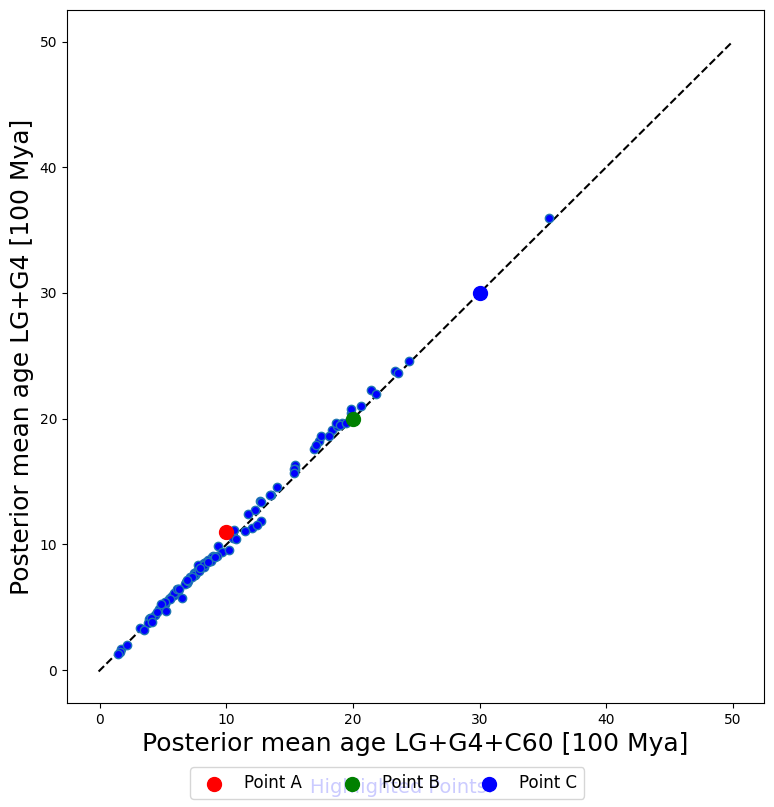

In [11]:
fig, ax = plt.subplots(figsize=(9 ,9))
ax.plot([-0.1,50], 
        [-0.1, 50], 
        'k--')
points = ax.plot(middle_LG_G4_x, middle_LG_G4_C60_y, 'o')
points[0].set_markerfacecolor('blue')

points_to_mark = [(10, 11), (20, 20), (30, 30)]
labels = ['Point A', 'Point B', 'Point C']
colors = ['red', 'green', 'blue']
# points[23].set_markerfacecolor('blue')# Set default face color (for other points)

# Now plot the highlighted point with a different color
# ax.scatter(posterior_mean_iqtree[0], posterior_mean_baseml[0], color='red', s=100)
# ax.scatter(posterior_mean_iqtree[-5], posterior_mean_baseml[-5], color='red', s=100)
# # ax.scatter(posterior_mean_iqtree[0], posterior_mean_baseml[0], color='red', label='Root age')
# ax.annotate('root calibration:\n B(33.4700, 45.2000)', 
#         xy=(model1_mean_posterior_times[0], model2_mean_posterior_times[0]), 
#         xytext=(model1_mean_posterior_times[0] -4,  model2_mean_posterior_times[0] + 2),  # Offset position for the label
#         arrowprops=dict(arrowstyle='->', color='red'),  # Arrow style
#         fontsize=12, color='red') 
# ax.annotate('middle calibration:\n B (10.3300, 45.2000)', 
#         xy=(model1_mean_posterior_times[-5], model2_mean_posterior_times[-5]), 
#         xytext=(model1_mean_posterior_times[-5] -6,  model2_mean_posterior_times[-5] + 10),  # Offset position for the label
#         arrowprops=dict(arrowstyle='->', color='red'),  # Arrow style
#         fontsize=12, color='red') 

for (px, py), color in zip(points_to_mark, colors):
        ax.scatter(px, py, color=color, marker='o', s=100, zorder=3)
# Labels and title
ax.set_xlabel('Posterior mean age LG+G4+C60 [100 Mya]', fontsize=18)
ax.set_ylabel('Posterior mean age LG+G4 [100 Mya]', fontsize=18)

# Adding a label below the x-axis title for all the subplots with colored dots
fig.text(0.5, 0.01, 'Highlighted Points: ', ha='center', fontsize=14, color='blue')
for label, color in zip(labels, colors):
    plt.scatter([], [], color=color, marker='o', s=100, label=label)
fig.legend(loc='lower center', ncol=3, fontsize=12)
# ax.set_title('Posterior mean age comparison between LG and LG+G4+C60 [t199 ~ B(10.3300,45.2000)]')
# ax.legend()


plt.show()

In [12]:
x_plot_data = []
y_plot_data = []

# LG_G4_C60 data
young_LG_G4_C60_y, young_LG_G4_x = compare_trees(LG_G4_index_tree, LG_G4_C60_index_tree,young_LG_G4_C60_dates, young_LG_G4_codeml_dates)

x_plot_data.append(young_LG_G4_x)
y_plot_data.append(young_LG_G4_C60_y)

middle_LG_G4_C60_y, middle_LG_G4_x = compare_trees(LG_G4_index_tree, LG_G4_C60_index_tree,middle_LG_G4_C60_dates, middle_LG_G4_codeml_dates)

x_plot_data.append(middle_LG_G4_x)
y_plot_data.append(middle_LG_G4_C60_y)

root_LG_G4_C60_y, root_LG_G4_x = compare_trees(LG_G4_index_tree, LG_G4_C60_index_tree,root_LG_G4_C60_dates, root_LG_G4_codeml_dates)

x_plot_data.append(root_LG_G4_x)
y_plot_data.append(root_LG_G4_C60_y)

# PM_MF_Q data

young_PM_MF_Q_y, young_LG_G4_q_x = compare_trees(LG_G4_index_tree, LG_G4_index_tree, young_MF_Q_dates, young_LG_G4_codeml_dates)

x_plot_data.append(young_LG_G4_q_x)
y_plot_data.append(young_PM_MF_Q_y)

middle_PM_MF_Q_y, middle_LG_G4_q_x = compare_trees(LG_G4_index_tree, LG_G4_index_tree,middle_MF_Q_dates, middle_LG_G4_codeml_dates)

x_plot_data.append(middle_LG_G4_q_x)
y_plot_data.append(middle_PM_MF_Q_y)

root_PM_MF_Q_y, root_LG_G4_q_x = compare_trees(LG_G4_index_tree, LG_G4_index_tree,root_MF_Q_dates, root_LG_G4_codeml_dates)

x_plot_data.append(root_LG_G4_q_x)
y_plot_data.append(root_PM_MF_Q_y)


# PM_MF_p data

young_PM_MF_p_y, young_LG_G4_p_x = compare_trees(LG_G4_index_tree, LG_G4_index_tree,young_MF_p_dates, young_LG_G4_codeml_dates)

x_plot_data.append(young_LG_G4_p_x)
y_plot_data.append(young_PM_MF_p_y)

middle_PM_MF_p_y, middle_LG_G4_p_x = compare_trees(LG_G4_index_tree, LG_G4_index_tree,middle_MF_p_dates, middle_LG_G4_codeml_dates)

x_plot_data.append(middle_LG_G4_p_x)
y_plot_data.append(middle_PM_MF_p_y)

root_PM_MF_p_y, root_LG_G4_p_x = compare_trees(LG_G4_index_tree, LG_G4_index_tree,root_MF_p_dates, root_LG_G4_codeml_dates)

x_plot_data.append(root_LG_G4_p_x)
y_plot_data.append(root_PM_MF_p_y)

In [19]:
for i in range(9):
    print(len(x_plot_data[i]), len(y_plot_data[i]))

101 101
101 101
101 101
101 0
101 0
101 0
101 101
101 101
101 101


ValueError: x and y must be the same size

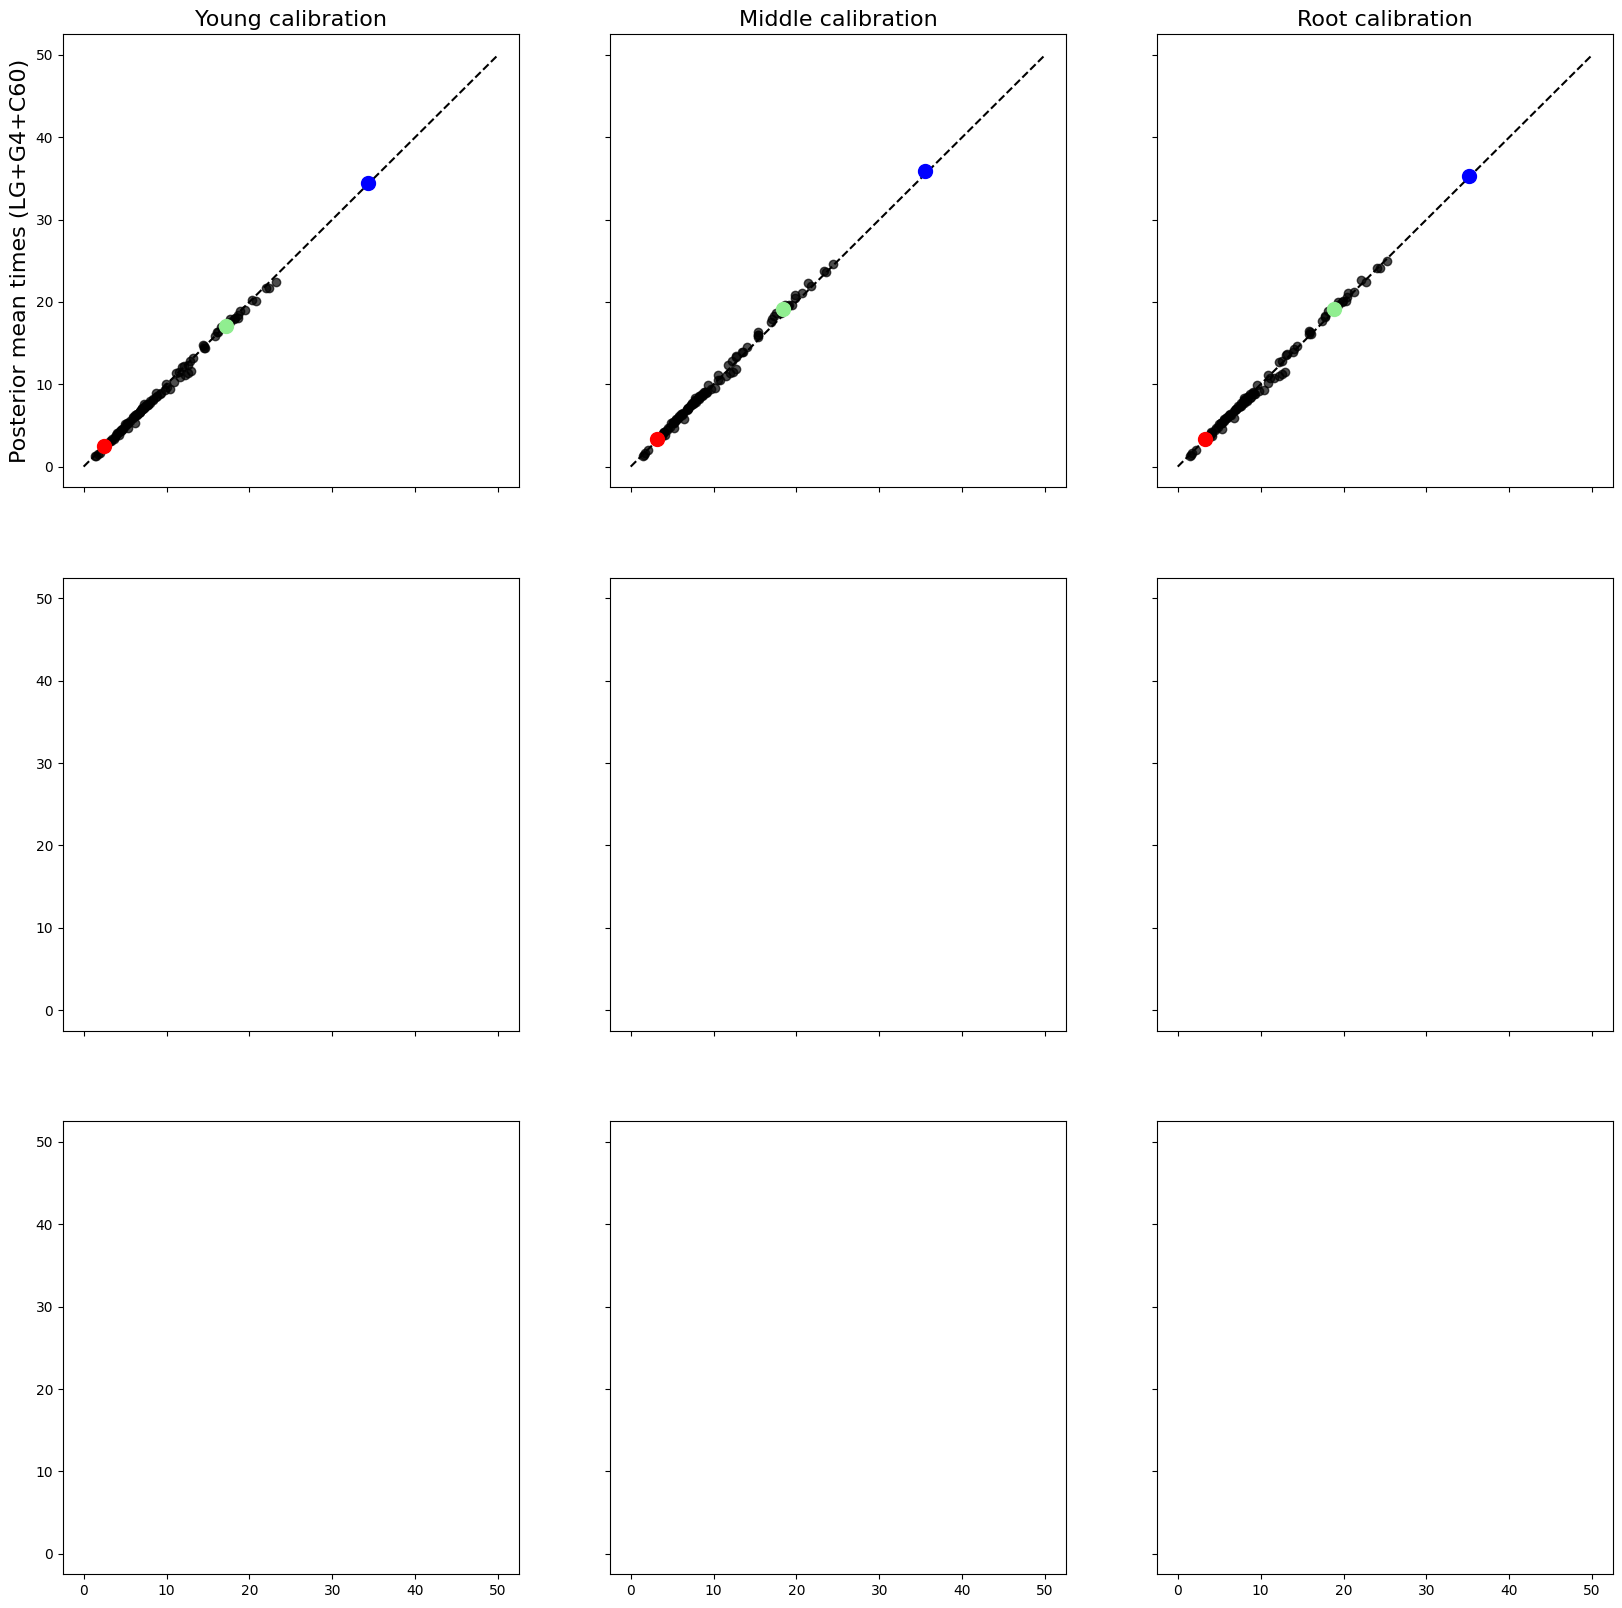

In [13]:

x = x_plot_data
y = y_plot_data

# Coordinates of the points to be marked
points_to_mark = [(14, 14), (5, 5), (0, 0)]
labels = ['Young calibration ~ B(1.2500,2.4820) ', 'Middle calibration ~ B(16.1910, 45.2000)',  'Root calibration ~ B(33.4700, 45.2000)']
colors = ['red', 'lightgreen', 'blue']

# Creating a new 3x4 subplot grid with different y-axis titles for each plot
fig, axes = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)

# Adding scatter plots to each subplot
for i, ax in enumerate(axes.flat):
    ax.scatter(x[i], y[i], alpha=0.7, color='black')
    ax.plot([0, 50], [0, 50], 'k--', linewidth=1.5)  # Adding y=x line
    # ax.set_title(f'Plot {i+1}')

    # Adding different y-axis titles for each plot
    if(i==0):
        ax.set_title('Young calibration', fontsize=16)
        ax.set_ylabel('Posterior mean times (LG+G4+C60)', fontsize=16)
    if(i==1):
        ax.set_title('Middle calibration', fontsize=16)
    if(i==2):
        ax.set_title('Root calibration', fontsize=16)
    if(i==3):
         ax.set_ylabel('Posterior mean times (ModelFinder [-Q])', fontsize=16)
    if(i==6):
         ax.set_ylabel('Posterior mean times (ModelFinder [-p])', fontsize=16)
    
    

    # Marking the given points in each subplot
    for (px, py), color in zip(points_to_mark, colors):
        ax.scatter(x[i][px], y[i][py], color=color, marker='o', s=100, zorder=3)

# Common labels
fig.text(0.5, 0.08, 'Posterior mean times (LG+G4)', ha='center', fontsize=16)
# fig.text(0.04, 0.5, 'Common Y axis', va='center', rotation='vertical', fontsize=16)

# Adding a label below the x-axis title for all the subplots with colored dots
fig.text(0.5, 0.01, 'Highlighted Points: ', ha='center', fontsize=14, color='blue')
for label, color in zip(labels, colors):
    plt.scatter([], [], color=color, marker='o', s=100, label=label)
fig.legend(loc='lower center', ncol=3, fontsize=12)

plt.tight_layout(rect=[0.05, 0.1, 1, 1])
# plt.show()
plt.savefig('./animal_origin_posterior_all_plots.png')
